# v2e Tutorial

This colab script is to demonstrate the use of v2e.

For more technical details, please find in our paper:
**v2e: From Video Frames to Realistic DVS Events** (https://arxiv.org/abs/2006.07722)

Our YouTube Tutorial: https://www.youtube.com/watch?v=THJqRC_q2kY&t

Colab provides free GPU resources, you can also use this script as a tool for converting videos to events.

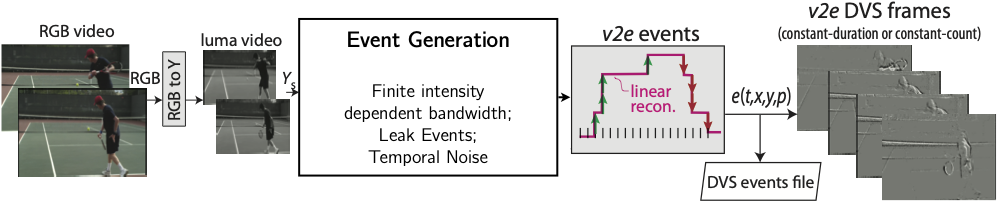

## Check Colab Runtime

**Make sure you are using GPU runtime. Otherwise, go to Runtime->Change runtime type to change.**

In [ ]:
!nvidia-smi  # check if the GPU is working properly
%rm -rf ./sample_data  # remove the sample data

/bin/bash: line 1: nvidia-smi: command not found


## Setup v2e

In [ ]:
# Installing dependencies
%pip install numba -q
%pip install engineering-notation -q
%pip install opencv-contrib-python -q
%pip install argcomplete -q
%pip install dv-processing -q

# other dependencies that's already preinstalled in the environment
# you need to install these additional dependencies in your local environment

# pip install torch torchvision -U  # Follow the instructions here: https://pytorch.org/get-started/locally/
# pip install numpy
# pip install matplotlib
# pip install h5py
# pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 52.7 MB/s eta 0:00:00


In [ ]:
# Clone and install
!git clone https://github.com/SensorsINI/v2e
%cd /content/v2e
#!python setup.py develop
%pip install .
!mkdir input
%cd /content/
%pwd

Cloning into 'v2e'...
remote: Enumerating objects: 3314, done.
remote: Counting objects: 100% (1084/1084), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 3314 (delta 981), reused 1007 (delta 926), pack-reused 2230
Receiving objects: 100% (3314/3314), 34.34 MiB | 29.30 MiB/s, done.
Resolving deltas: 100% (2446/2446), done.
/content/v2e
Processing /content/v2e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.3/142.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 58.0 MB/s eta 0:00:00
  Created wheel for v2e: filename=v2e-1.5.1-py3-none-any.whl size=116984 sha256=0cf4b164e600e2500f7d37d5fb7af4bb29dc0c70fba51b46e64e98257eb85c8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-kabbqb07/wheels/77/5f/75/585e5c0362b6f0da630814aee1b3cce77ba29bfd5274e7fa38
Successfully built v2e
  Attempting uninstall: numpy
    Fo

'/content'

In [ ]:
# download super-slomo checkpoint
# actual checkpoint is here: https://drive.google.com/file/d/1ETID_4xqLpRBrRo1aOT7Yphs3QqWR_fx/view?usp=sharing
# in local environment, download and put it in the folder /path/to/v2e/input

import gdown

url = 'https://drive.google.com/uc?id=1ETID_4xqLpRBrRo1aOT7Yphs3QqWR_fx'
output = '/content/v2e/input/SuperSloMo39.ckpt'  # The name you want to save the file as
gdown.download(url, output, quiet=False)
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ETID_4xqLpRBrRo1aOT7Yphs3QqWR_fx' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ETID_4xqLpRBrRo1aOT7Yphs3QqWR_fx" -O /content/v2e/input/SuperSloMo39.ckpt && rm -rf /tmp/cookies.txt

Downloading...
From (original): https://drive.google.com/uc?id=1ETID_4xqLpRBrRo1aOT7Yphs3QqWR_fx
From (redirected): https://drive.google.com/uc?id=1ETID_4xqLpRBrRo1aOT7Yphs3QqWR_fx&confirm=t&uuid=4b8fcd7a-a52a-4fca-afd5-ee8956549b4a
To: /content/v2e/input/SuperSloMo39.ckpt
100%|██████████| 158M/158M [00:03<00:00, 45.4MB/s]


'/content/v2e/input/SuperSloMo39.ckpt'

## Upload a Video

### If you have data on your Google Drive (Recommend)

Click file explorer on the left, there are three buttons on the top: Upload, Refresh and Mount Drive.

Click "Mount Drive", Colab will ask for your permission to mount.
Once you agreed, the drive will be mounted at `/content/drive`


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# If the video is a zip file, decompress it and remove the file
# otherwise, you can ignore this

# select the video path again here
#@title In the file explorer, right click the video file, and then click "Copy Path". Then, paste the path here: { run: "auto", vertical-output: true }
video_path = '"/content/drive/MyDrive/Colab Notebooks/fall-detection/UP-Fall Detection/Subject1/Activity1/Trial1/Subject1Activity1Trial1Camera1.zip"' #@param {type:"string"}
unzip_path = 'v2e-input'

if ".zip" in video_path:
    # decompress the file
    !unzip $video_path -d $unzip_path
    video_path = unzip_path

## Convert the Video to Events!

In [ ]:
#@title **Configure V2E Options** { run: "auto", vertical-output: true, display-mode: "both" }
#@markdown The full documentation is here: https://github.com/SensorsINI/v2e#render-emulated-dvs-events-from-conventional-video

#@markdown This GUI supports only common use configs, for finer control, please check the v2e documentation and edit the code below.

#@markdown ---
#@markdown ## Output Options

output_folder = "/content/v2e-output" #@param {type:"string"}
#@markdown - folder to store outputs. (default: v2e-output)
overwrite = False #@param {type:"boolean"}
#@markdown - overwrites files in existing folder (checks existence of non-empty output_folder). (default: True)
unique_output_folder = True #@param {type:"boolean"}
#@markdown - makes unique output folder based on output_folder, e.g. output1 (if non-empty output_folder already exists) (default: False)
out_filename = "events.h5" #@param {type:"string"}
#@markdown - Output DVS events as hdf5 event database.
davis_output = True #@param {type:"boolean"}
#@markdown - If also save frames in HDF5. (default: False)

#@markdown ### Output DVS Video Options
skip_video_output = False #@param {type:"boolean"}
#@markdown - Skip producing video outputs, including the original video, SloMo video, and DVS video (default: False)
dvs_exposure = "duration 0.033" #@param {type:"string"}
#@markdown - Mode to finish DVS frame event integration: duration time: Use fixed accumulation time in seconds, e.g. --dvs_exposure duration .005; count n: Count n events per frame, -dvs_exposure count 5000; area_event N M: frame ends when any area of M x M pixels fills with N events, -dvs_exposure area_count 500 64 (default: duration 0.01)
output_mode = "dvs240" #@param ["dvs128", "dvs240", "dvs346", "dvs640", "dvs1024"]
#@markdown - This option sets the output size of the v2e. Supported models: "dvs128" (128x128), "dvs240" (240x180), "dvs346" (346x260), "dvs640" (640x480), "dvs1024" (1024x768).

#@markdown ---

#@markdown ## Input Options
input_frame_rate = 30 #@param {type:"number"}
#@markdown - Manually define the video frame rate when the video is presented as a list of image files. When the input video is a video file, this option will be ignored.
input_slowmotion_factor =  1#@param {type:"number"}
#@markdown - Sets the known slow-motion factor of the input video, i.e. how much the video is slowed down, i.e., the ratio of shooting frame rate to playback frame rate. input_slowmotion_factor<1 for sped-up video and input_slowmotion_factor>1 for slowmotion video.If an input video is shot at 120fps yet is presented as a 30fps video (has specified playback frame rate of 30Hz, according to file's FPS setting), then set --input_slowdown_factor=4.It means that each input frame represents (1/30)/4 s=(1/120)s.If input is video with intended frame intervals of 1ms that is in AVI file with default 30 FPS playback spec, then use ((1/30)s)*(1000Hz)=33.33333. (default: 1.0)

#@markdown ---

#@markdown ## DVS Time Resolution Options
disable_slomo = True #@param {type:"boolean"}
#@markdown - Disables slomo interpolation; the output DVS events will have exactly the timestamp resolution of the source video (which is perhaps modified by --input_slowmotion_factor). (default: False)
timestamp_resolution = 0.1 #@param {type:"number"}
#@markdown - (Ignored by --disable_slomo.) Desired DVS timestamp resolution in seconds; determines slow motion upsampling factor; the video will be upsampled from source fps to achieve the at least this timestamp resolution.I.e. slowdown_factor = (1/fps)/timestamp_resolution; using a high resolution e.g. of 1ms will result in slow rendering since it will force high upsampling ratio. Can be combind with --auto_timestamp_resolution to limit upsampling to a maximum limit value. (default: None)
auto_timestamp_resolution = False #@param {type:"boolean"}
#@markdown - (Ignored by --disable_slomo.) If True (default), upsampling_factor is automatically determined to limit maximum movement between frames to 1 pixel. If False, --timestamp_resolution sets the upsampling factor for input video. Can be combined with --timestamp_resolution to ensure DVS events have at most some resolution. (default: False)

# This is the SloMo model path
slomo_model = "/content/v2e/input/SuperSloMo39.ckpt"

#@markdown ---

#@markdown ## DVS Model Options
condition = "Clean" #@param ["Custom", "Clean", "Noisy"]
#@markdown - Custom: Use following slidebar to adjust your DVS model.
#@markdown - Clean: a preset DVS model, generate clean events, without non-idealities.
#@markdown - Noisy: a preset DVS model, generate noisy events.

thres = 0.2 #@param {type:"slider", min:0.05, max:1, step:0.01}
#@markdown - threshold in log_e intensity change to trigger a positive/negative event. (default: 0.2)
sigma = 0.03 #@param {type:"slider", min:0.01, max:0.25, step:0.001}
#@markdown - 1-std deviation threshold variation in log_e intensity change. (default: 0.03)
cutoff_hz = 200 #@param {type:"slider", min:0, max:300, step:1}
#@markdown - photoreceptor first-order IIR lowpass filter cutoff-off 3dB frequency in Hz - see https://ieeexplore.ieee.org/document/4444573 (default: 300)
leak_rate_hz = 5.18 #@param {type:"slider", min:0, max:100, step:0.01}
#@markdown - leak event rate per pixel in Hz - see https://ieeexplore.ieee.org/abstract/document/7962235 (default: 0.01)
shot_noise_rate_hz = 2.716 #@param {type:"slider", min:0, max:100, step:0.001}
#@markdown - Temporal noise rate of ON+OFF events in darkest parts of scene; reduced in brightest parts. (default: 0.001)

if condition == "Clean":
    thres = 0.2
    sigma = 0.02
    cutoff_hz = 0
    leak_rate_hz = 0
    shot_noise_rate_hz = 0
elif condition == "Noisy":
    thres = 0.2
    sigma_thres = 0.05
    cutoff_hz = 30
    leak_rate_hz = 0.1
    shot_noise_rate_hz = 5

#@markdown ---

v2e_command = ["v2e"]

# set the input folder
# the video_path can be a video file or a folder of images
v2e_command += ["-i", video_path]

# set the output folder
v2e_command += ["-o", output_folder]

# if the output will rewrite the previous output
if overwrite:
    v2e_command.append("--overwrite")

# if there the output folder is unique
v2e_command += ["--unique_output_folder", "{}".format(unique_output_folder).lower()]

# set output configs, for the sake of this tutorial, let's just output HDF5 record
if davis_output:
    v2e_command += ["--ddd_output"]
v2e_command += ["--dvs_h5", out_filename]
v2e_command += ["--dvs_aedat2", "None"]
v2e_command += ["--dvs_text", "None"]

# in Colab, let's say no preview
v2e_command += ["--no_preview"]

# if skip video output
if skip_video_output:
    v2e_command += ["--skip_video_output"]
else:
    # set DVS video rendering params
    v2e_command += ["--dvs_exposure", dvs_exposure]

# set slomo related options
v2e_command += ["--input_frame_rate", "{}".format(input_frame_rate)]
v2e_command += ["--input_slowmotion_factor", "{}".format(input_slowmotion_factor)]

# set slomo data
if disable_slomo:
    v2e_command += ["--disable_slomo"]
    v2e_command += ["--auto_timestamp_resolution", "false"]
else:
    v2e_command += ["--slomo_model", slomo_model]
    if auto_timestamp_resolution:
        v2e_command += ["--auto_timestamp_resolution", "{}".format(auto_timestamp_resolution).lower()]
    else:
        v2e_command += ["--timestamp_resolution", "{}".format(timestamp_resolution)]

# threshold
v2e_command += ["--pos_thres", "{}".format(thres)]
v2e_command += ["--neg_thres", "{}".format(thres)]

# sigma
v2e_command += ["--sigma_thres", "{}".format(sigma)]

# DVS non-idealities
v2e_command += ["--cutoff_hz", "{}".format(cutoff_hz)]
v2e_command += ["--leak_rate_hz", "{}".format(leak_rate_hz)]
v2e_command += ["--shot_noise_rate_hz", "{}".format(shot_noise_rate_hz)]

# append output mode
v2e_command += [f"--{output_mode}"]

# Final v2e command

final_v2e_command = " ".join(v2e_command)

print("The Final v2e command:")
display(final_v2e_command)


In [ ]:
# Run command!
!$final_v2e_command

## Quick Visualization and Output Summary

In [ ]:
# Output file path
import os
import h5py
import pandas as pd

output_folder = "/content/v2e-output"
out_filepath = os.path.join(output_folder, out_filename)
out_dataset = h5py.File(out_filepath, "r")

file_stats = os.stat(out_filepath)

# Summarize file

events = out_dataset["events"]

num_events = events.shape[0]
duration = (events[-1, 0]-events[0, 0])/1e6  # in seconds
event_rate = num_events/duration/1000

display("File Size (MB): {:.2f}".format(file_stats.st_size / (1024*1024)))
display("Number of Events: {}".format(events.shape[0]))
display("Recording Duration: {:.2f}s".format(duration))
display("Event Rate: {:.2f} KEVs/s".format(event_rate))

df = pd.DataFrame(events, columns=["timestamp", "x", "y", "polarity"])
unique_timestamps = df['timestamp'].unique().tolist()
display("No of micro second timestamps: {}".format(len(unique_timestamps)))
display("Timestamps per second: {:.2f}".format(len(unique_timestamps)/duration))

# Divide the 'timestamp' column by 1000 and round to the nearest integer
df['timestamp'] = (df['timestamp'] / 1000).round().astype(int)
unique_timestamps = df['timestamp'].unique().tolist()
display("No of mili second timestamps: {}".format(len(unique_timestamps)))
display(unique_timestamps[:20])

In [ ]:
import matplotlib.pyplot as plt

# Group by 'timestamp' and count the number of events at each timestamp
events_per_timestamp = df.groupby('timestamp').size()

# Plotting
plt.figure(figsize=(10, 6))
events_per_timestamp.plot(kind='line')

plt.title('Number of Events per Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Number of Events')

plt.tight_layout()
plt.show()

In [ ]:
# DVS Video
dvs_vid_path = os.path.join(output_folder, "dvs-video.avi")
!ffmpeg -y -i $dvs_vid_path /tmp/output.mp4 -loglevel quiet

from IPython.display import HTML
from base64 import b64encode
mp4 = open("/tmp/output.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("<video controls src={} width=50%/>".format(data_url))

## Beyond Single File Conversion

This tutorial setup is for a single file conversion.
For multiple files, the ideal way is to use `v2e.py` script as subprocesses like we showed here.

For a simple demonstration, please checkout the following example for converting
the Caltech-101 dataset.

Link: https://gist.github.com/duguyue100/f60bdc1eb0e5b51586ca3594d9d72cb7

In [ ]:
import os
import subprocess
import shlex

data_root = "/content/drive/MyDrive/Colab Notebooks/fall-detection/UP-Fall Detection"
output_folder = "/content/drive/MyDrive/Colab Notebooks/fall-detection/har-up-spiking-dataset-240"

def get_zip_files(root_folder):
    zip_files = []
    # Walk through the directory structure starting from root_folder.
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.startswith('Subject') and filename.endswith('.zip'):
                # If the file is a .zip file, append its path to zip_files list.
                zip_file_path = os.path.join(dirpath, filename)
                zip_files.append(zip_file_path)
    return zip_files

# Get image folders list
zipped_image_folders = get_zip_files(data_root)
print(len(zipped_image_folders))

for zip_file in zipped_image_folders:
    folder_name = zip_file.split("/")[-1].replace(".zip", "")

    out_folder = os.path.join(output_folder, folder_name)
    if os.path.exists(out_folder):
      continue

    unzip_path = f"har-up-extracted/{folder_name}"
    os.makedirs(unzip_path, exist_ok=True)

    zip_file_string = f'"{zip_file}"'
    !unzip $zip_file_string -d $unzip_path

    os.makedirs(out_folder)

    out_filename = f"{folder_name}.h5"

    v2e_command = f"v2e -i \"{unzip_path}\" -o \"{out_folder}\" --overwrite --unique_output_folder false --ddd_output --dvs_h5 {out_filename} --dvs_aedat2 None --dvs_text None --no_preview --dvs_exposure duration 0.033 --input_frame_rate 30 --input_slowmotion_factor 1 --disable_slomo --auto_timestamp_resolution false --pos_thres 0.2 --neg_thres 0.2 --sigma_thres 0.02 --cutoff_hz 0 --leak_rate_hz 0 --shot_noise_rate_hz 0 --dvs240"
    v2e_command_list = shlex.split(v2e_command)
    print(v2e_command_list)

    subprocess.run(v2e_command_list)
    %rm -rf $unzip_path


Streaming output truncated to the last 5000 lines.
  inflating: har-up-extracted/Subject10Activity11Trial1Camera2/2018-07-09T13_59_42.775990.png  
  inflating: har-up-extracted/Subject10Activity11Trial1Camera2/2018-07-09T13_59_42.820108.png  
  inflating: har-up-extracted/Subject10Activity11Trial1Camera2/2018-07-09T13_59_42.872252.png  
  inflating: har-up-extracted/Subject10Activity11Trial1Camera2/2018-07-09T13_59_42.915367.png  
  inflating: har-up-extracted/Subject10Activity11Trial1Camera2/2018-07-09T13_59_42.972525.png  
  inflating: har-up-extracted/Subject10Activity11Trial1Camera2/2018-07-09T13_59_43.024663.png  
  inflating: har-up-extracted/Subject10Activity11Trial1Camera2/2018-07-09T13_59_43.071796.png  
  inflating: har-up-extracted/Subject10Activity11Trial1Camera2/2018-07-09T13_59_43.116916.png  
  inflating: har-up-extracted/Subject10Activity11Trial1Camera2/2018-07-09T13_59_43.162040.png  
  inflating: har-up-extracted/Subject10Activity11Trial1Camera2/2018-07-09T13_59_43.20

In [ ]:
# import shutil

# dataset_folder = "/content/drive/MyDrive/Colab Notebooks/fall-detection/urfd-spiking-dataset-240"
# file_name = dataset_folder.split("/")[-1]

# # Zip the folder
# zip_path = shutil.make_archive(file_name, 'zip', dataset_folder)

# shutil.move(zip_path, dataset_folder.replace(file_name, ""))